# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
\
\

In [1]:
#https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages = 3 

2022-09-21 21:46:49.419898: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 21:46:49.419922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [3]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [4]:
#path = './data/Zero_Day/'
path = './new_data/'
path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_combine = path +'VAE_syntheticdata_combine_epoch10_2000000.csv'
path_attack = path + 'attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
normal_df['marker'] = normal_df.apply(label_marker, axis=1)
attack_df['marker'] = attack_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
normal_label = normal_df['marker'].to_numpy() 
attack_label = attack_df['marker'].to_numpy() 
print(len(combine_labels))
print(len(normal_label))
print(len(attack_label))

#adding noise to x_train
#noise = np.random.normal(0, NOISE, traffic_np_norm.shape)

1571591
1000000
55663


In [5]:
# Delete marker column 
normal_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)

normal shape (1000000, 128)
attack shape (55663, 128)
combine shape (1571591, 128)


In [7]:
combine_df = combine_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
combine_scaled = scaler.fit_transform(combine_df)

normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [8]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(55663, 128)
(1000000, 128)


In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [10]:
#x_train = traffic_np_norm[...,np.newaxis]
#x_combine = combine_np_norm[...,np.newaxis]
#x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", X_train.shape)
print("Combine Traffic Test input shape: ", X_test.shape)

Normal Traffic Training input shape:  (800000, 128)
Combine Traffic Test input shape:  (255663, 128)


In [11]:
input_dim = X_train.shape[1]
encoding_dim = X_train.shape[1]

def build_model_ANN():
   input_ANN = layers.Input(shape=(input_dim, ))
#   encoder = layers.Dropout(rate=0.2)(input_ANN)
   encoder = layers.Dense(1024, activation='relu')(input_ANN)
   encoder = layers.Dense(512, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(128, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(32, activation='relu')(encoder)
   decoder = layers.Dropout(rate=0.2)(encoder)
   decoder = layers.Dense(128, activation='relu')(decoder)
   decoder = layers.Dropout(rate=0.2)(decoder)
   decoder = layers.Dense(512, activation='tanh')(decoder)
   decoder = layers.Dense(1024, activation='tanh')(decoder)
   out_layer = layers.Dense(encoding_dim, activation = 'tanh')(decoder)
   autoencoder = keras.Model(inputs=input_ANN, outputs=out_layer)
   return autoencoder

def build_model_CNN():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

In [12]:
# We arange dimensions to work with CNN or ANN
# Remember CNN has an additional dimension at the end

keras.backend.clear_session()

if NETWORK == 'CNN':
    model = build_model_CNN()
    noise = noise[...,np.newaxis]
elif NETWORK == 'ANN':
    model = build_model_ANN()
    x_train = np.squeeze(X_train)
    x_attack = np.squeeze(X_test)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                4128  

2022-09-21 21:48:33.603038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-21 21:48:33.604125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-21 21:48:33.604258: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-21 21:48:33.604378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-21 21:48:33.632825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [13]:
#noise.shape

In [14]:
## Train the model

#Note that we are using `X_train` as both the input and the target
#since this is a reconstruction model.
#"""
#x_train_noisy = x_train + noise

history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.17,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
5188/5188 [==============================] - 60s 11ms/step - loss: 0.0201 - val_loss: 0.0169
Epoch 2/50
5188/5188 [==============================] - 63s 12ms/step - loss: 0.0181 - val_loss: 0.0162
Epoch 3/50
5188/5188 [==============================] - 63s 12ms/step - loss: 0.0175 - val_loss: 0.0158
Epoch 4/50
5188/5188 [==============================] - 61s 12ms/step - loss: 0.0171 - val_loss: 0.0154
Epoch 5/50
5188/5188 [==============================] - 62s 12ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 6/50
5188/5188 [==============================] - 62s 12ms/step - loss: 0.0167 - val_loss: 0.0151
Epoch 7/50
5188/5188 [==============================] - 62s 12ms/step - loss: 0.0166 - val_loss: 0.0148
Epoch 8/50
5188/5188 [==============================] - 62s 12ms/step - loss: 0.0165 - val_loss: 0.0149
Epoch 9/50
5188/5188 [==============================] - 62s 12ms/step - loss: 0.0164 - val_loss: 0.0147
Epoch 10/50
5188/5188 [==============================] - 62s 12m

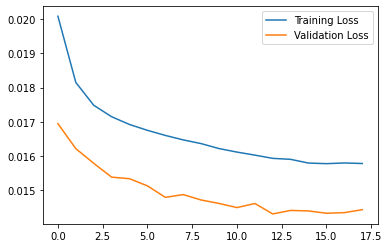

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [16]:
# we use RMSE as reconstruction error (can use MAE as well)
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [17]:
# Prediction of training vector
X_train_pred = model.predict(X_train)
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error \
      {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.989)
print('error threshold >>>', error_thresh)

Avg error 0.07258486776377786
median error       0.07111768184755529
99Q: 0.11717280541096825
error threshold >>> 0.11654253080951152


In [18]:
# application of error threshold in test vector
# A vector of anomalies is created with the points that go over the threshold

X_pred = model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

total length vector anomalies :  255663
Number of anomalies :  46393
total length of y_test vector 255663
total lenght of attacks in y_test vector 55663


In [19]:
# Sklearn classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    200000
         1.0       0.95      0.79      0.87     55663

    accuracy                           0.95    255663
   macro avg       0.95      0.89      0.92    255663
weighted avg       0.95      0.95      0.95    255663



In [20]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = model.predict(X_test)
# PCA transformation to observe variance in 2 components

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_pred2)

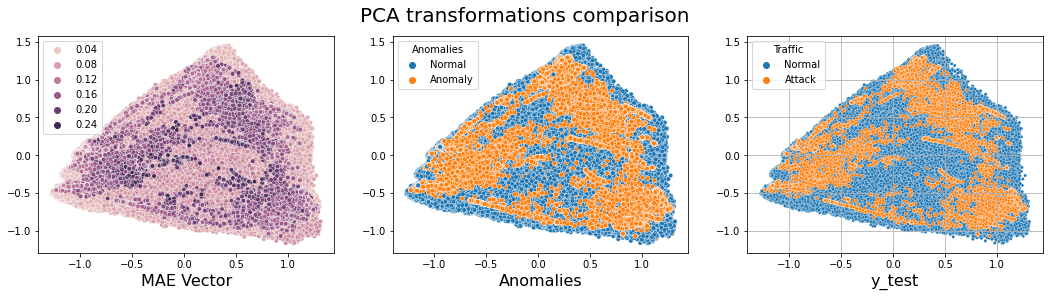

In [21]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Normal', 'Anomaly'], title='Anomalies')
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Normal', 'Attack'], title='Traffic')
plt.grid()
plt.show()

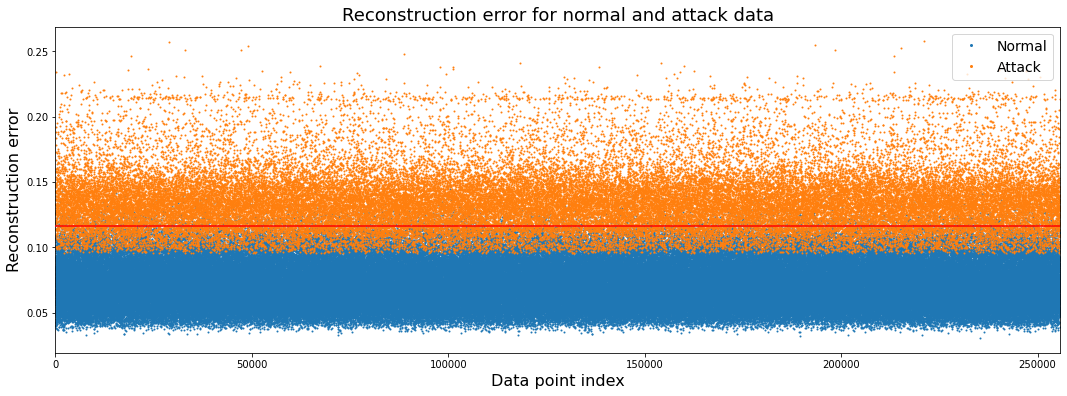

In [22]:
# Reconstruction figure
plt.rc('legend',fontsize=14)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1, linestyle='',
            label= "Attack" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
plt.xlim(0,error_df.shape[0])
# leg = ax.legend()
# leg.set_title('Traffic',prop={'size':14})
legend_label, _ = ax.get_legend_handles_labels()
plt.legend(legend_label, ['Normal', 'Attack'], prop={'size': 14}, 
          loc="upper right", markerscale=2., scatterpoints=1)
plt.title("Reconstruction error for normal and attack data", size=18)
plt.ylabel("Reconstruction error", size=16)
plt.xlabel("Data point index", size = 16)
plt.show()

In [26]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (55663,) 
 Normal_error shape (200000,)


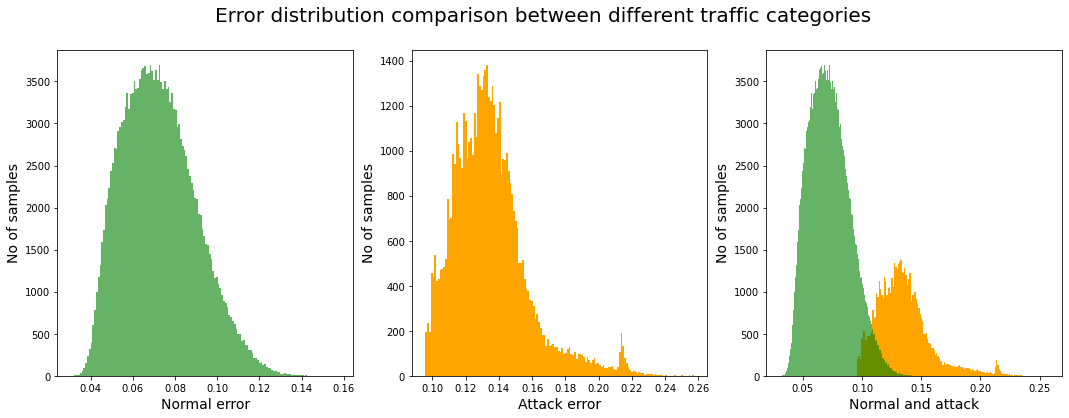

In [27]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

In [23]:
#=================================================

In [24]:
#EOF